In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import plotly.express as px
from scipy.stats import ttest_ind
import scipy
import warnings
import os
from datetime import datetime as dt
warnings.filterwarnings("ignore")
from google.colab import drive
import os
drive.mount('/content/drive')

os.chdir('/content/drive/MyDrive/Alexes_Bansal_Lab/Prison Vaccinaiton Project/')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
## Opening data from cleaned data
file=open('Data/Cleaned/jurisdiction_temporal.csv')

#Creating main data frame: correcting for date format and making sure NA values are removed
df=pd.read_csv(file)
df['Date']=pd.to_datetime(df['Date'], format="%Y-%m-%d")
df.reset_index()
df=df.drop('Unnamed: 0',axis=1)
states=df['State'].unique()
df

,index,Date,State,Residents.Initiated,Month,Year,Population_Dec2021,Residents.Initiated.Rate,Prioritization?,Date_prioritized,Phase_state,Mono.Initiated.Coverage,Days,Days_since_last
0,7252,2021-03-28,Wisconsin,680.0,3,2021,20088.0,0.033851,yes,2021-03-01,1C,0.033851,0,NaN
1,7253,2021-04-04,Wisconsin,1380.0,4,2021,20088.0,0.068698,yes,2021-03-01,1C,0.068698,7,7.0
2,7254,2021-04-11,Wisconsin,3291.0,4,2021,20088.0,0.163829,yes,2021-03-01,1C,0.163829,14,7.0
3,7255,2021-04-18,Wisconsin,3886.0,4,2021,20088.0,0.193449,yes,2021-03-01,1C,0.193449,21,7.0
4,7256,2021-04-25,Wisconsin,6435.0,4,2021,20088.0,0.320341,yes,2021-03-01,1C,0.320341,28,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014,142,2022-12-11,Alabama,14322.0,12,2022,18279.0,0.783522,yes,2021-04-01,1B,0.783522,616,7.0
2015,143,2022-12-18,Alabama,14322.0,12,2022,18279.0,0.783522,yes,2021-04-01,1B,0.783522,623,7.0
2016,144,2023-01-01,Alabama,14322.0,1,2023,18279.0,0.783522,yes,2021-04-01,1B,0.783522,637,14.0
2017,145,2023-01-08,Alabama,14322.0,1,2023,18279.0,0.783522,yes,2021-04-01,1B,0.783522,644,7.0


In [ ]:
# Get non-incarcerated vacc data
df_noninc=pd.read_csv("https://data.cdc.gov/api/views/unsk-b7fc/rows.csv")
df_noninc.Location.unique()
df_noninc = df_noninc[df_noninc.Location == 'US']
df_noninc['Date']=pd.to_datetime(df_noninc['Date'], format="%m/%d/%Y")
df_noninc = df_noninc[(df_noninc.Date > '2/14/2021') & (df_noninc.Date < '04/01/2022')]
df_noninc['Administered_Dose1_Pop_Pct'] = df_noninc['Administered_Dose1_Pop_Pct']/100 # convert to proportion


In [ ]:
##COMBINING NON-INCARCERATED AND INCARCERATED VACCINATION DATA
from datetime import timedelta

## loop adds data to match the information from the week before.
for date in df_noninc['Date'].unique():
  national=df_noninc[df_noninc['Date']==date].reset_index()['Administered_Dose1_Pop_Pct'].iloc[0]

  week_before=[]
  for i in range (1,8):
    week_entry=date - timedelta(i)
    week_before.append(week_entry)
  df_date=df.loc[df['Date'].isin(week_before)]
  df_date.sort_values('Date')
  number_above=0

  for state in df_date['State'].unique():
    coverage=df_date.loc[df_date['State']==state].reset_index()['Mono.Initiated.Coverage'].iloc[0]
    if coverage>national:
      number_above=number_above+1

## Graphing States Overall

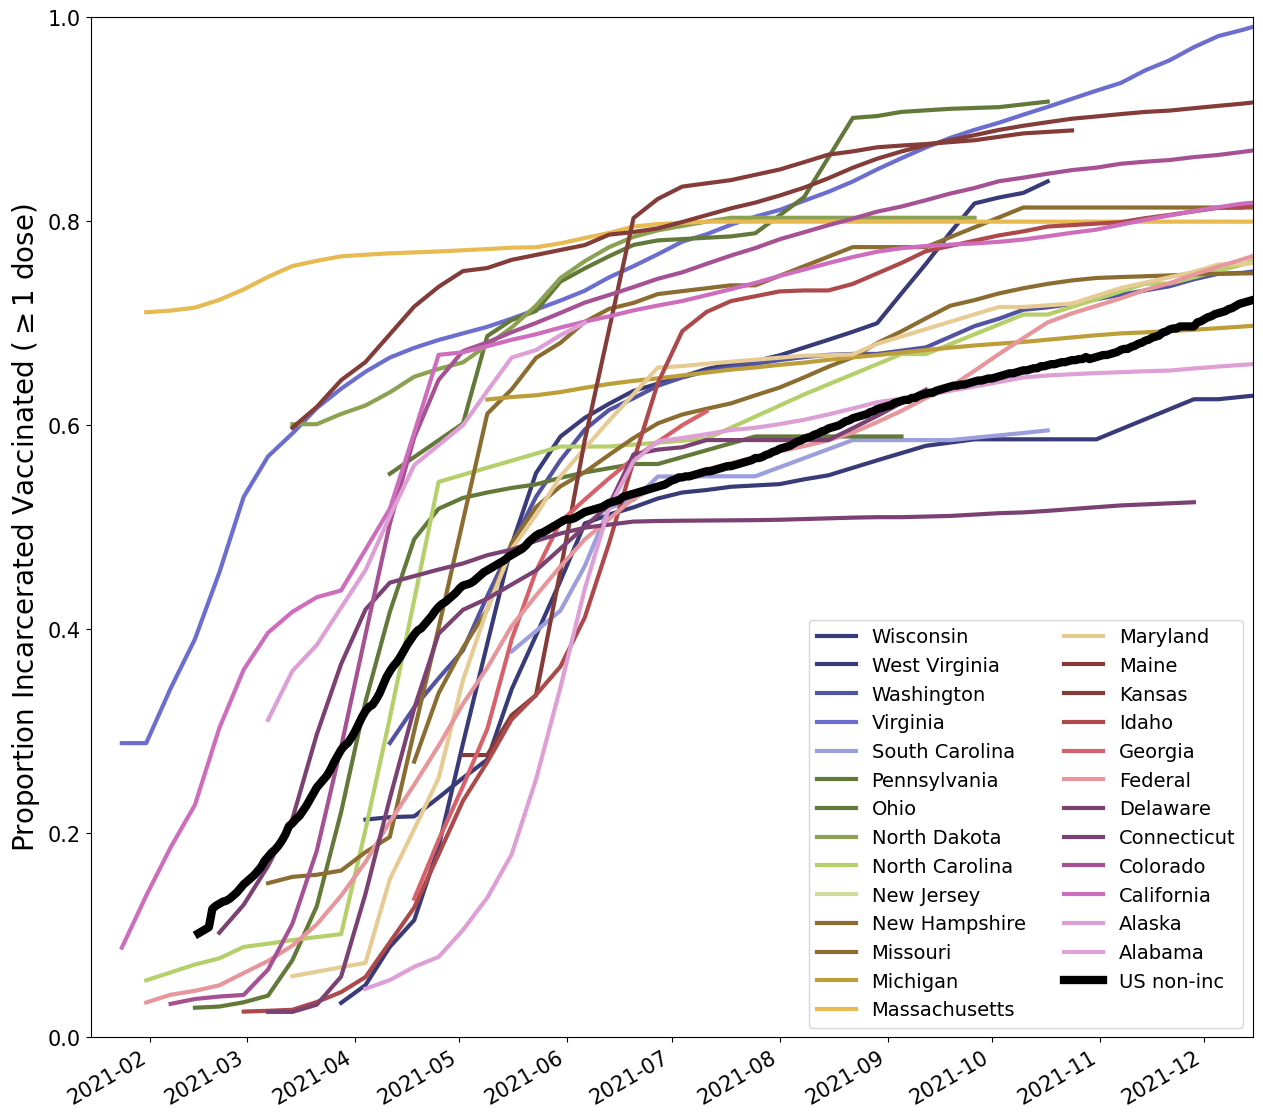

In [ ]:
##Graphing non-incarcerated coverage
fig, ax = plt.subplots(figsize = (15,15))
df.dropna(subset=['Mono.Initiated.Coverage'], inplace=True)
states=df['State'].unique()

colormap = plt.cm.tab20b
colors = [colormap(i) for i in np.linspace(0, 1,len(states))]
ax.set_prop_cycle('color', colors)
for state in states:
    df2=df.loc[df['State'] == state]
    for name, group in df2.groupby("State"):

        # shweta addition to smooth the time series
        group = group[['Date', 'Mono.Initiated.Coverage']]
        group = group.sort_values(by='Date')
        group = group.set_index('Date')
        group = group.rolling('28d').mean()
        group = group.reset_index()

        group.plot(x='Date', y='Mono.Initiated.Coverage', ax=ax,label=state, linewidth=3)

df_noninc.plot(x= 'Date', y= 'Administered_Dose1_Pop_Pct', color = 'black', linewidth = 6, ax=ax, label='US non-inc')

plt.legend(ncol=2, loc="best", fontsize = 14)
ax.set_ylabel('Proportion Incarcerated Vaccinated ($\geq 1$ dose)', fontsize=20)
ax.set_xlabel('')
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_xlim(['01/15/2021', '12/15/2021'])
ax.set_ylim(0,1)
fig.savefig('Graphs/Vaccination Coverage.jpg')

# Calculating the vaccination rate for all states
We need all states because we also will use the vaccinaiton rate to determine days to saturation

In [ ]:
## Calculate the vaccination rate of change
df["Rate.Change"] = " "
df['Differences']=np.nan
df_concat=pd.DataFrame()


for state in states:
    df_state=df.loc[df['State']==state]
    df_state['Rate.Change'][0]=np.nan
    df_state['Rate.Change'][1]=np.nan
    ##Calculations for rate of change
    df_state['Differences']=((np.log(df_state['Mono.Initiated.Coverage']))-(np.log(df_state['Mono.Initiated.Coverage'].shift(1))))
    df_state['Days_since_last']=df_state['Days_since_last'].astype(float, errors = 'raise')
    df_state['Rate.Change']=df_state['Differences']/(df_state['Days_since_last'])
    df_concat= pd.concat([df_state,df_concat])
df=df_concat ##renaming the new dataframe with all the stored rates as df




Takeawy: Calculating days to Saturation needs to be (0--> 0.005) and initial rate should be 30 days

## Function to match states to their abbreviations

In [ ]:
##Creating a fucntion to add in state name abbreviations
states_abbrevs = {'AK':'Alaska','AL':'Alabama','AR':'Arkansas','AZ':'Arizona', 'CA':'California','CO':'Colorado',
    'CT':'Connecticut','DC':'District of Columbia','DE':'Delaware','FL':'Florida','GA':'Georgia',
    'HI':'Hawaii','IA':'Iowa','ID':'Idaho','IL':'Illinois','IN':'Indiana','KS':'Kansas','KY':'Kentucky','LA':'Louisiana',
    'MA':'Massachusetts','MD':'Maryland','ME':'Maine','MI':'Michigan','MN':'Minnesota','MO':'Missouri','MS':'Mississippi',
    'MT':'Montana','NC':'North Carolina','ND':'North Dakota','NE':'Nebraska','NH':'New Hampshire','NJ':'New Jersey',
    'NM':'New Mexico','NV':'Nevada','NY':'New York','OH':'Ohio','OK':'Oklahoma','OR':'Oregon','PA':'Pennsylvania',
    'RI':'Rhode Island','SC':'South Carolina','SD':'South Dakota','TN':'Tennessee','TX':'Texas','UT':'Utah',
    'VA':'Virginia','VT':'Vermont','WA':'Washington','WI':'Wisconsin','WV':'West Virginia','WY':'Wyoming'}


def best_match(x):
    if len(x) == 2: # Try another way for 2-letter codes
        for a,n in states_abbrevs.items():
            if len(n.split()) == 2:
                if "".join([c[0] for c in n.split()]).lower() == x.lower():
                    return a.lower()
    new_rx = re.compile(r"\w*".join([ch for ch in x]), re.I)
    for a,n in states_abbrevs.items():
        if new_rx.match(n):
            return a.upper()

## Calculating Initial Vaccination Rate

In [ ]:
bad_rate_states=[] ##Creating a list to store states have a rate greater than 50% in a given week
for state in states:  ##Checking each state
    df_state=df.loc[df['State']==state]
    df_state.sort_values(by='Date',ascending=True)
    xs=df_state.index.to_list()
    first=xs[0] ##fiest calue in th index
    start_rate=df_state['Mono.Initiated.Coverage'][first] ##pulling the first value from every state

    if start_rate>0.5:
        bad_rate_states.append(state)

states=list(states)
states_for_rates=[i for i in states if i not in bad_rate_states] #list of states that are good to use for Calculating rate
## Creating a list of states without the federal prison designation
statesonly=states
statesonly.remove('Federal')

In [ ]:
## Creating a dataset to store covariates for analysis starting with mean initial rate
values=[] ##empty list to store tuples for the mean and std for rate of change
for state in states_for_rates:
    df_state=df.loc[df['State']==state]
    df_state=df_state.loc[df_state['Days']<30] ## Initial rate for the first 30 days of the vaccination campaign
    df_state.dropna(subset=['Rate.Change'],inplace=True)
    mean=df_state['Rate.Change'].mean()
    values.append((state,mean))
df_means = pd.DataFrame(values, columns=['State','Rate_change_mean_perday'])
df_means['Rate_change_mean_perweek']=df_means['Rate_change_mean_perday']*7



df_means=df_means.loc[df_means['State'].isin(statesonly)]
df_means['state_code'] = df_means['State'].apply(lambda x: best_match(x))

## Calculating vaccination saturation

In [ ]:
def all_5_list_values(list1,lower,upper):
    if lower<list1[0]<upper:
        if lower<list1[1]<upper:
            if lower<list1[2]<upper:
                if lower<list1[3]<upper:
                    if lower<list1[4]<upper:
                        if lower<list1[5]<upper:
                            return True

In [ ]:
##Creating a dataset to keep track of the states days to saturation (known as slow date in this code)
state_stop=[]
for state in states:## for every state in the data set
    df_state=df.loc[df['State']==state] ##Create data for just that state
    df_state=df_state.sort_values(by='Days',ascending=True)
    index_list=df_state.index.values.tolist() ##Create a list of the indexes for the dataframe
    true_for_state=[] #Create an empty list to store all the index values for which the this state meets the requirements
    for value in range(0,(len(index_list)-6)):##for every value
        next_ten=index_list[value:value+6] ##the index value and the following
        next_ten_values=list(df_state['Rate.Change'][next_ten])
        if all_5_list_values(next_ten_values,0,0.005)==True:
            index=index_list[value]
            true_for_state.append(index)
    if len(true_for_state) >0:
        first=true_for_state[0]
        ##fix follwoing line
        day=df_state['Days'][first]
        state_stop.append([state,day])
df_slow=pd.DataFrame(state_stop,columns=['State','Slow_date'])

## December Coverage & Comparison to Non incarcerated

In [ ]:
##Pulling coverage for each state in the 48th week of 2021 for december non-incarcerated coverage
file_state=open('Data/Cleaned/data_county_timeseries.csv')
df_noninc=pd.read_csv(file_state)
df_noninc=df_noninc.loc[df_noninc['CASE_TYPE']=='Partial']
df_noninc=df_noninc.loc[df_noninc['WEEK']==48]
df_noninc=df_noninc.loc[df_noninc['YEAR']==2021]
df_noninc['State']=df_noninc['STATE_NAME'].replace(states_abbrevs)
df_new_december=pd.DataFrame()

In [ ]:
## Combining non incarcerated vaccination coverage with the first data entry for every state in December 2021
december=[]
df_december=pd.DataFrame()
for state in df['State'].unique():
    df_state_noninc=df_noninc.loc[df_noninc['State']==state]
    ppl_vacc=df_state_noninc['CASES'].sum()
    popn=df_state_noninc['POPN'].sum()
    state_coverage_non_inc=ppl_vacc/popn

    df_state=df.loc[df['State']==state]
    df_state_12=df_state.loc[df_state['Date'].dt.month==12]
    df_state_12=df_state_12.loc[df_state_12['Date'].dt.year==2021]
    index_list=df_state_12.index.values.tolist() ##Create a list of the indexes for the dataframe
    if len(index_list)>0:
        first=index_list[0]
        december_value=df_state_12['Mono.Initiated.Coverage'][first]
        december.append([state,december_value])
    else: december.append([state,np.nan])
    new_row=[state,december_value,state_coverage_non_inc]
    new_row=pd.DataFrame({'State':[state], 'Coverage_december':[december_value], 'non_inc_coverage':[state_coverage_non_inc]})
    df_december=pd.concat([df_december,new_row],ignore_index=True)

df_december.columns=['State', 'Coverage_december', 'non_inc_coverage']

df_december['diff_in_coverage']=df_december['Coverage_december']-df_december['non_inc_coverage']
print(df_december)

             State  Coverage_december  non_inc_coverage  diff_in_coverage
0          Alabama           0.661251          0.528682          0.132569
1           Alaska           0.661251          0.609991          0.051259
2       California           0.817236          0.704373          0.112863
3         Colorado           0.869876          0.795482          0.074394
4      Connecticut           0.869876          0.832608          0.037268
5         Delaware           0.869876          0.707149          0.162727
6          Federal           0.767545               NaN               NaN
7          Georgia           0.767545          0.323806          0.443739
8            Idaho           0.813883          0.497817          0.316065
9           Kansas           0.917507          0.620479          0.297028
10           Maine           0.917507          0.790403          0.127104
11        Maryland           0.758044          0.763537         -0.005493
12   Massachusetts           0.799733 

## Creating dataframe with all analysis data

In [ ]:
##Combining all covariate data frames into one.
df_analysis=pd.DataFrame(df['State'].unique(),columns=['State'])
df_analysis=df_analysis.set_index('State')
df_december=df_december.set_index('State')
df_slow=df_slow.set_index('State')
df_means=df_means.set_index('State')
df_analysis=pd.concat([df_december,df_slow,df_means,df_analysis],axis=1, verify_integrity=True)
df_analysis=df_analysis.reset_index()
df_analysis['state_code'] = df_analysis['State'].apply(lambda x: best_match(x))

print(df_analysis)

             State  Coverage_december  non_inc_coverage  diff_in_coverage  \
0          Alabama           0.661251          0.528682          0.132569   
1           Alaska           0.661251          0.609991          0.051259   
2       California           0.817236          0.704373          0.112863   
3         Colorado           0.869876          0.795482          0.074394   
4      Connecticut           0.869876          0.832608          0.037268   
5         Delaware           0.869876          0.707149          0.162727   
6          Federal           0.767545               NaN               NaN   
7          Georgia           0.767545          0.323806          0.443739   
8            Idaho           0.813883          0.497817          0.316065   
9           Kansas           0.917507          0.620479          0.297028   
10           Maine           0.917507          0.790403          0.127104   
11        Maryland           0.758044          0.763537         -0.005493   

In [ ]:
df_analysis.to_csv('analysis.csv')

# Graphing

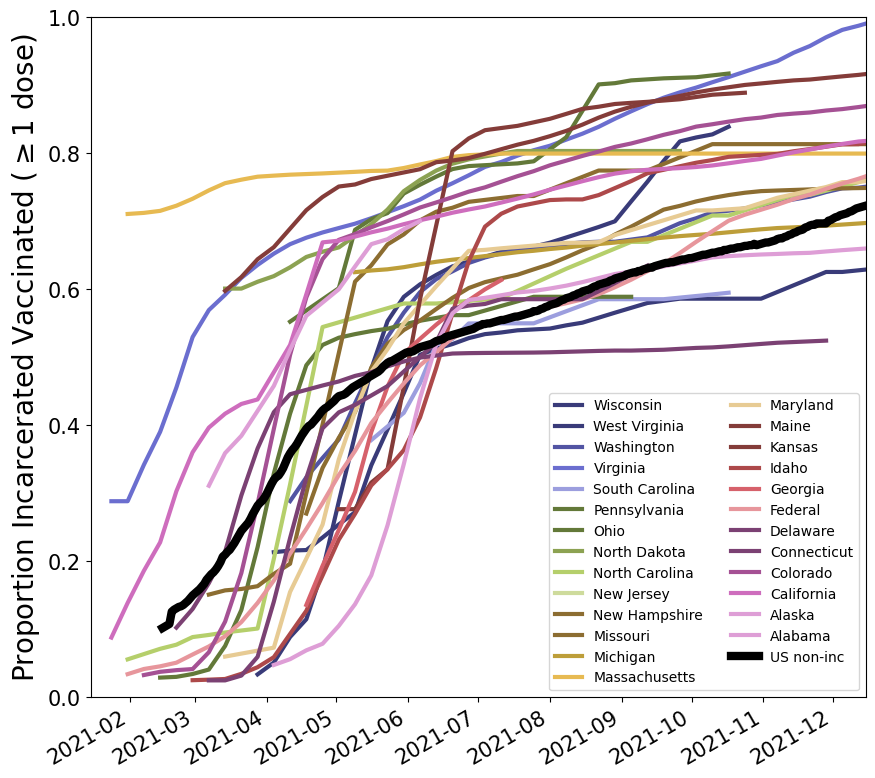

In [ ]:
import geopandas as gpd

fig_timeseries,timeseries = plt.subplots(figsize=(10, 10))

# Get non-incarcerated vacc data
df_noninc=pd.read_csv("https://data.cdc.gov/api/views/unsk-b7fc/rows.csv")
df_noninc.Location.unique()
df_noninc = df_noninc[df_noninc.Location == 'US']
df_noninc['Date']=pd.to_datetime(df_noninc['Date'], format="%m/%d/%Y")
df_noninc = df_noninc[(df_noninc.Date > '2/14/2021') & (df_noninc.Date < '04/01/2022')]
df_noninc['Administered_Dose1_Pop_Pct'] = df_noninc['Administered_Dose1_Pop_Pct']/100 # convert to proportion

df_analysis=pd.read_csv('analysis.csv')
df=pd.read_csv('Data/Cleaned/UCLA_statewide_temporal.csv')
#Creating main data frame: correcting for date format and making sure NA values are removed


df['Date']=pd.to_datetime(df['Date'], format="%Y-%m-%d")
#df = df[df['Mono.Initiated.Coverage'].notna()]
df.reset_index()
df=df.drop('Unnamed: 0',axis=1)
states=df['State'].unique()

len(df['Date'].unique())
df.dropna(subset=['Mono.Initiated.Coverage'], inplace=True)
states=df['State'].unique()


colormap = plt.cm.tab20b
colors = [colormap(i) for i in np.linspace(0, 1,len(states))]
timeseries.set_prop_cycle('color', colors)

for state in states:
    df2=df.loc[df['State'] == state]

    for name, group in df2.groupby("State"):

        # shweta addition to smooth the time series
        group = group[['Date', 'Mono.Initiated.Coverage']]
        group = group.sort_values(by='Date')
        group = group.set_index('Date')
        group = group.rolling('28d').mean()
        group = group.reset_index()

        group.plot(x='Date', y='Mono.Initiated.Coverage', ax=timeseries,label=state, linewidth=3)
        #if state in df_concat['State'].unique():
            #df3.plot('Date', 'Mono.Initiated.Coverage', ax=ax,style='--',label='_nolegend_')

# shweta addition: add national partial vacc time series
df_noninc.plot(x= 'Date', y= 'Administered_Dose1_Pop_Pct', color = 'black', linewidth = 6, ax=timeseries, label='US non-inc')

timeseries.set_ylim(0,1)
timeseries.legend(ncol=2, loc="best", fontsize = 10)
timeseries.set_ylabel('Proportion Incarcerated Vaccinated ($\geq 1$ dose)', fontsize=20)
timeseries.set_xlabel('')
timeseries.tick_params(axis='both', which='major', labelsize=15)
timeseries.set_xlim(['01/15/2021', '12/15/2021'])
fig_timeseries.savefig('figure1_timeseries.png',dpi=1000)
############################################################################## PLOTTING COVERAGE IN DECEMBER ###################################################################################################

df_analysis=df_analysis.rename(columns={'state_code':'STUSPS'})

fig = px.choropleth(df_analysis, locations='STUSPS',locationmode='USA-states', color="Coverage_december", scope="usa")
fig.update_layout(coloraxis_colorbar_title_text = 'December Coverage')
fig.update_coloraxes(colorbar_title_side="top")
fig.update_layout(coloraxis_colorbar=dict(
    orientation="h",
    x=0.5,
    y=-0.2,
    xanchor="center",
    yanchor="bottom"
))
fig.update_geos(
    visible=False, resolution=110, scope="usa",
    showsubunits=True, subunitcolor="Black", subunitwidth=2
)
fig.update_layout(coloraxis_colorbar=dict(tickfont=dict(size=14,color='black'),titlefont=dict(size=20,color='black')))
fig.update_traces(marker_line_color='black', marker_line_width=1)
fig.write_image('figure1_decembercoverage.png')
fig.show()
############################################################################## PLOTTING SATURATION ###################################################################################################
fig = px.choropleth(df_analysis, locations='STUSPS',locationmode='USA-states', color="Slow_date", scope="usa")
fig.update_layout(coloraxis_colorbar_title_text = 'Days to Saturation')
fig.update_coloraxes(colorbar_title_side="top")
fig.update_layout(coloraxis_colorbar=dict(
    orientation="h",
    x=0.5,
    y=-0.2,
    xanchor="center",
    yanchor="bottom"
))
fig.update_geos(
    visible=False, resolution=110, scope="usa",
    showsubunits=True, subunitcolor="Black", subunitwidth=2
)
fig.update_layout(coloraxis_colorbar=dict(tickfont=dict(size=14,color='black'),titlefont=dict(size=25,color='black')))

fig.update_traces(marker_line_color='black', marker_line_width=1)
fig.write_image('figure1_saturation.png')
fig.show()
####################################################################################PLOTTING INITIAL RATE#######################################################################################
fig = px.choropleth(df_analysis, locations='STUSPS',locationmode='USA-states', color="Rate_change_mean_perday", scope="usa")
fig.update_layout(coloraxis_colorbar_title_text = 'Initial Vaccination Rate')
fig.update_coloraxes(colorbar_title_side="top")
fig.update_layout(coloraxis_colorbar=dict(
    orientation="h",
    x=0.5,
    y=-0.2,
    xanchor="center",
    yanchor="bottom"
))
fig.update_geos(
    visible=False, resolution=110, scope="usa",
    showsubunits=True, subunitcolor="Black", subunitwidth=2
)
fig.update_layout(coloraxis_colorbar=dict(tickfont=dict(size=14,color='black'),titlefont=dict(size=25,color='black')))

fig.write_image('figure1_initialrate.png')
fig.show()
